# End-fed Half-wave Dipole
In this notebook, an end-fed half-wave dipole is modeled using the thin-wire MoM implementation.
 - Input impedance versus frequency
 - Standing wave ratio

In [1]:
using CairoMakie
using TimerOutputs

include("../src/Mesh.jl")
include("../src/Sources.jl")
include("../src/Matrix.jl")
include("../src/PostProcessing.jl")
include("../src/Visualization.jl")

plot_mesh (generic function with 1 method)

In [2]:
ε = 8.854e-12      # Vacuum permittivity [F/m]
μ = 4e-7 * π       # Vacuum permeability [H/m]

c = 1 / √(μ * ε)   # Speed of light in vacuum [m/s]
η = √(μ / ε)       # Impedance of vacuum [Ω]

376.73430918211017

# Generate mesh
Generate the mesh consisting of a single segment with $N_{el}$ elements. For the wire radius $a = 10^{-3}$, the antenna is resonant when it has a length of $0.479 \lambda$. The antenna wire is placed along the $y$-axis.

In [3]:
Nel = 35
l = 20.8
a = 3e-3

nodes, edges = mesh_segment([0 0 0], [l 0 0], Nel, 1)
end_points = get_end_points(nodes, edges)
basis_vecs = assign_basis_vector(nodes, edges)

msh = Mesh(nodes, edges, end_points, basis_vecs, a)

Mesh([0.0 0.0 0.0; 0.5942857142857143 0.0 0.0; … ; 20.205714285714286 0.0 0.0; 20.8 0.0 0.0], [[1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10], [10, 11]  …  [26, 27], [27, 28], [28, 29], [29, 30], [30, 31], [31, 32], [32, 33], [33, 34], [34, 35], [35, 36]], [1, 36], [-1.0 0.0 0.0; -1.0 0.0 0.0; … ; -1.0 0.0 0.0; -1.0 0.0 0.0], 0.003)

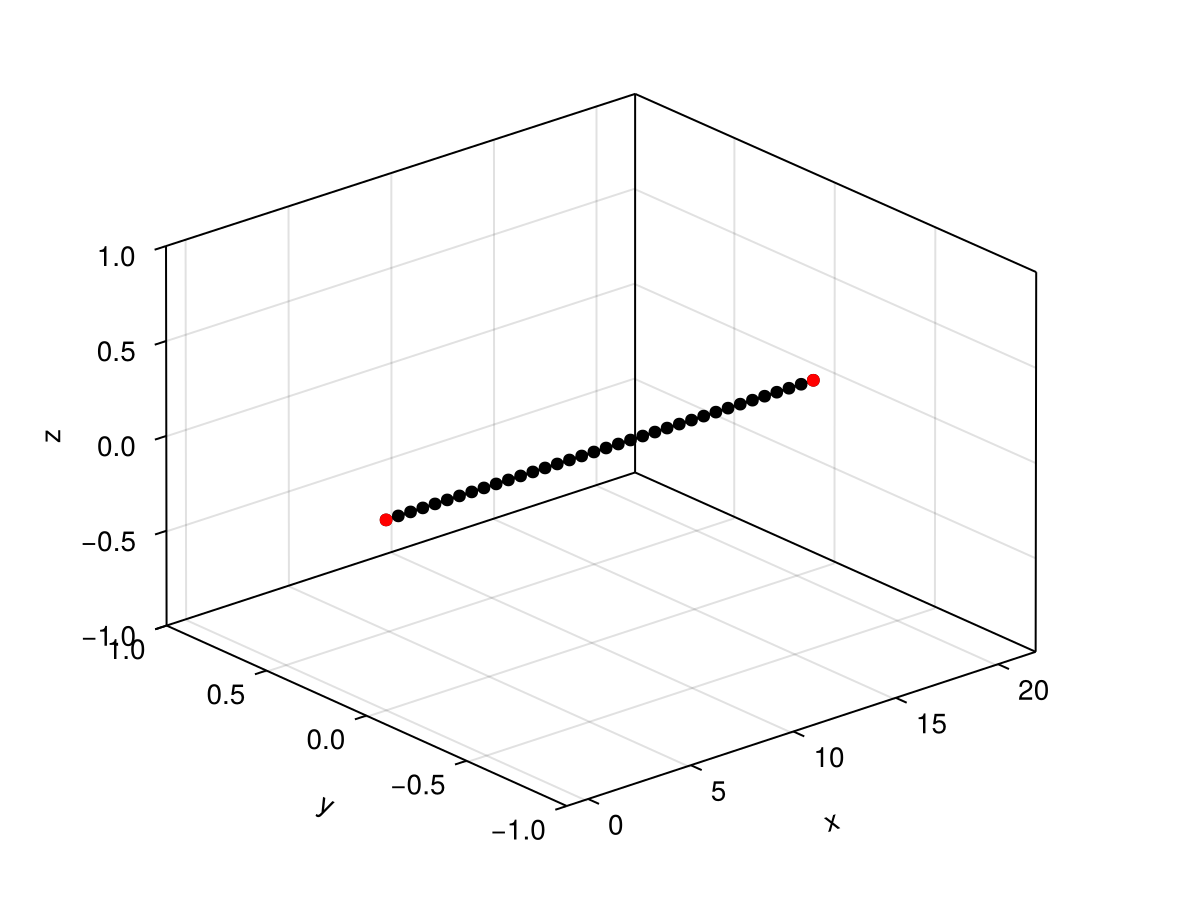

In [4]:
# Plot the antenna in 3D
f_msh = plot_mesh(msh)
f_msh

# Sources
The antenna is fed at the end by a delta-gap voltage source $V_{in}$.

In [5]:
# Mid-point feed
Vin = 1
idx_mid = Integer(1) # Index of center element
src1 = VoltageSource(Vin, idx_mid)

src = [src1]

1-element Vector{VoltageSource}:
 VoltageSource(1, 1)

# Frequency sweep
Next, we can solve the current distribution for a range of frequencies and plot the input impedance vs frequency.

In [6]:
# Input impedance frequency sweep
frequencies = range(1e6, 30e6, 200)
Zin = zeros(Complex{Float64}, length(frequencies))

reset_timer!()

@timeit "frequency sweep" for (i, f) ∈ enumerate(frequencies)
    # Assemble system equations
    @timeit "assembly" Z, V = assemble_global(msh, src, f, μ, ε)

    # Solve system
    @timeit "solve" Isol = Z \ V

    # Calculate input impedance
    e = msh.edges[src[1].edge]
    Iin = sum(Isol[e]) / length(Isol[e])
    Zin[i] = Vin / Iin
end

print_timer()

────────────────────────────────────────────────────────────────────────────
                                   Time                    Allocations      
                          ───────────────────────   ────────────────────────
    Tot / % measured:          14.1s /  97.1%           7.72GiB /  99.7%    

Section           ncalls     time    %tot     avg     alloc    %tot      avg
────────────────────────────────────────────────────────────────────────────
frequency sweep        1    13.7s  100.0%   13.7s   7.70GiB  100.0%  7.70GiB
  assembly           200    12.2s   89.0%  60.9ms   7.56GiB   98.2%  38.7MiB
    outer loop       200    11.3s   82.4%  56.4ms   7.48GiB   97.2%  38.3MiB
      element       245k    9.85s   71.9%  40.2μs   7.05GiB   91.6%  30.2KiB
  solve              200    1.39s   10.2%  6.95ms    136MiB    1.7%   699KiB
────────────────────────────────────────────────────────────────────────────


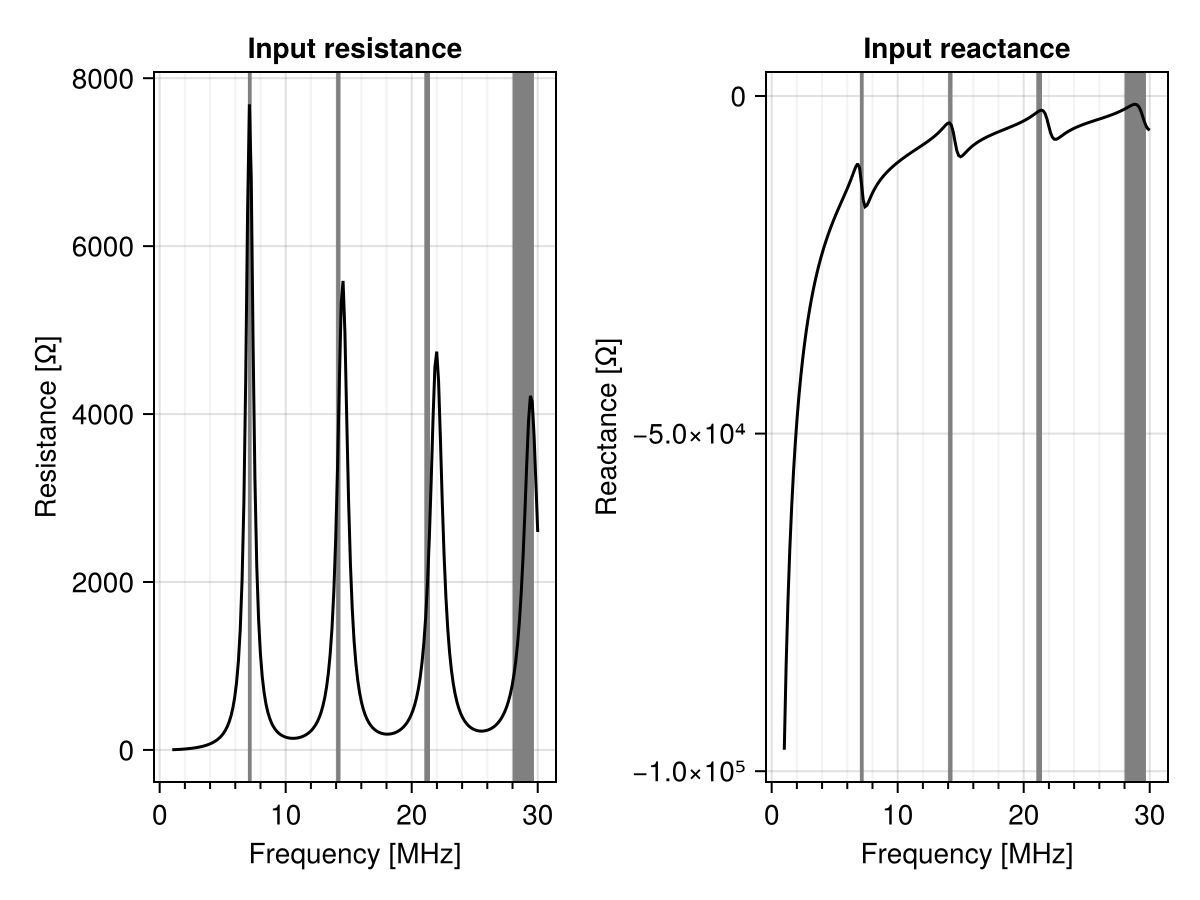

In [7]:
fig = Figure()
ax1 = Axis(
    fig[1, 1],
    xlabel="Frequency [MHz]", ylabel="Resistance [Ω]", title="Input resistance",
    xminorticksvisible=true, xminorgridvisible=true, xminorticks=IntervalsBetween(5)
)

flow = [7.0, 14.0, 21.0, 28.0]
fhigh = [7.3, 14.35, 21.45, 29.7]
vspan!(ax1, flow, fhigh, color = :gray)
lines!(ax1, frequencies * 1e-6, real.(Zin), color=:black)

ax2 = Axis(
    fig[1, 2],
    xlabel="Frequency [MHz]", ylabel="Reactance [Ω]", title="Input reactance",
    xminorticksvisible=true, xminorgridvisible=true, xminorticks=IntervalsBetween(5)
)

vspan!(ax2, flow, fhigh, color = :gray)
lines!(ax2, frequencies * 1e-6, imag.(Zin), color=:black)

fig

The impedance predicted at the lower frequencies is a bit higher than usual (typically around $2.5\,\mathrm{k\Omega}$) due to the complete lack of parasitic coupling to nearby metallic structures. Because of the high feed-point impedance, these antennas are usually driven by a 1:9 unun (1:49 impedance transformation ratio). Plotting the standing wave ratio (SWR) seen looking into the unun, we get quite good performance on the 10, 15, and 20 meter bands. With a tuner, we can also work on the 40 meter band.

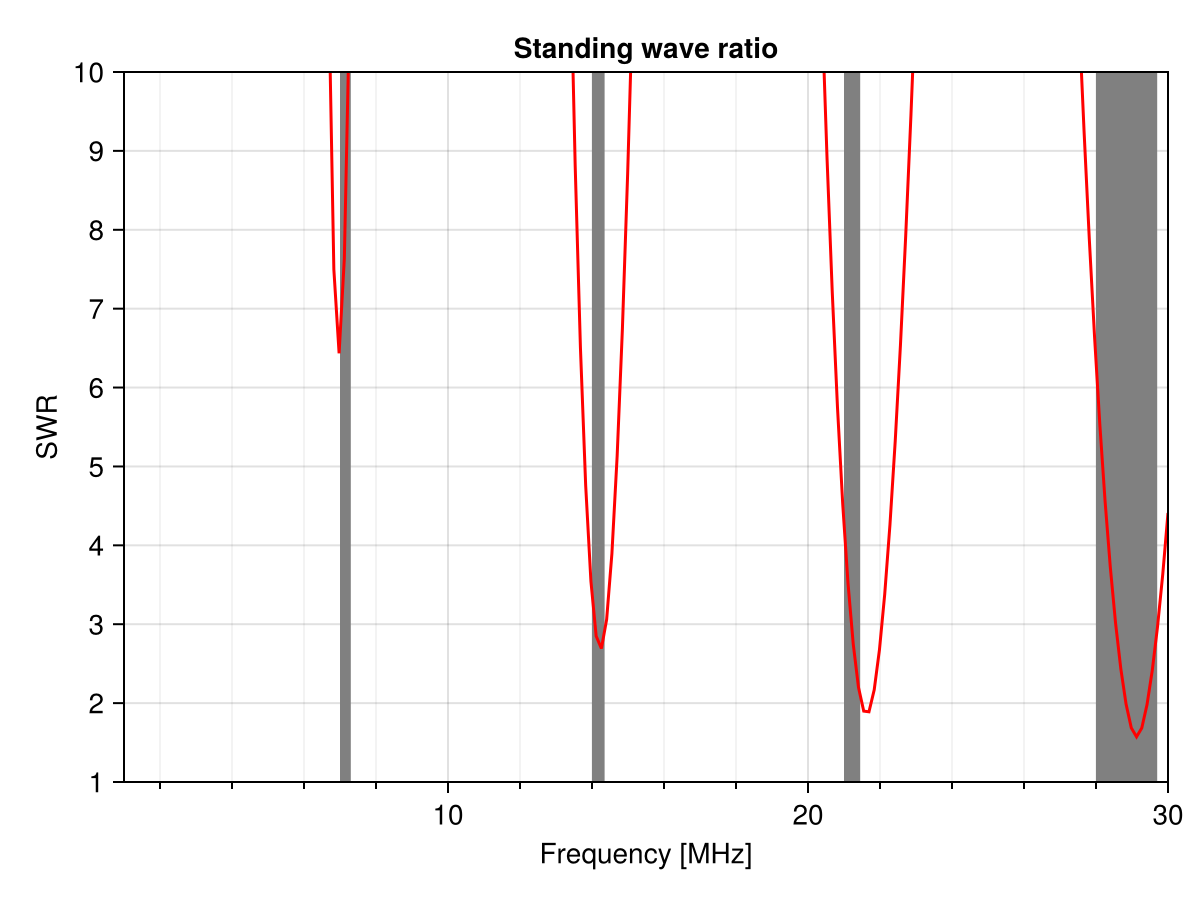

In [8]:
Z = Zin / 9^2

Z0 = 50
Γ = (Z .- Z0) ./ (Z .+ Z0)
SWR = (1 .+ abs.(Γ)) ./ (1 .- abs.(Γ))

fig = Figure()
ax1 = Axis(
    fig[1, 1],
    xlabel="Frequency [MHz]", ylabel="SWR", title="Standing wave ratio",
    xminorticksvisible=true, xminorgridvisible=true, xminorticks=IntervalsBetween(5),
    limits = (1, 30, 1, 10)
)

vspan!(ax1, flow, fhigh, color = :gray)
lines!(ax1, frequencies * 1e-6, SWR, color = :red)

fig

Plotting the reflection coefficient in the complex plane shows the capacitive nature of the antenna. 

`Makie.jl` does not support Smith charts.

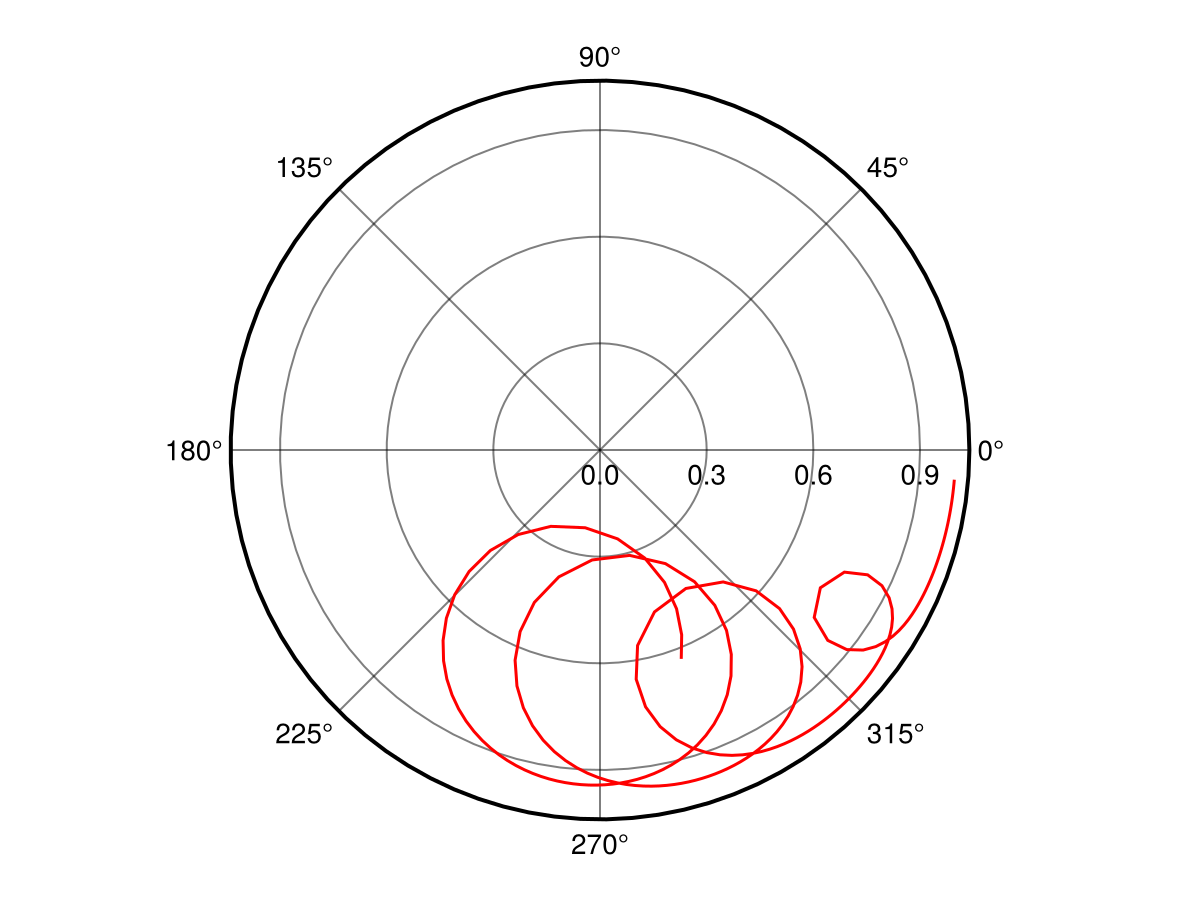

In [9]:
fig = Figure()
ax1 = PolarAxis(fig[1, 1])

lines!(ax1, angle.(Γ), norm.(Γ), color = :red)

fig